In [6]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Librerias para el funcionamiento del algoritmo Jerárquico Divisivo
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cut_tree

In [7]:
data = pd.read_csv("train.csv") 

In [8]:
Dy=data['price_range'].to_numpy()
Dx=data[['ram','battery_power']].to_numpy()

In [9]:
np.unique(Dy)

array([0, 1, 2, 3])

### Medidas de evaluación

In [10]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i],cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k]/(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/(np.sum(mat[l,:]))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([(np.sum(mat[:,k])/np.sum(mat))
                   * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])
def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

### Kmeans

Centros encontrados por...
el método programado
el método de Sci-kit Learn
[[3506.34392523 1270.77757009]
 [1543.07352941 1291.47689076]
 [ 669.345898   1219.44789357]
 [2483.55762082 1175.57063197]]
Matriz de confusión:
[[  0  94 405   1]
 [  0 315  46 139]
 [ 97  66   0 337]
 [439   0   0  61]]
El valor del error cometido es =  0.252
La pureza del agrupamiento obtenido es =  0.748
El valor F1 es =  0.7486762089053258


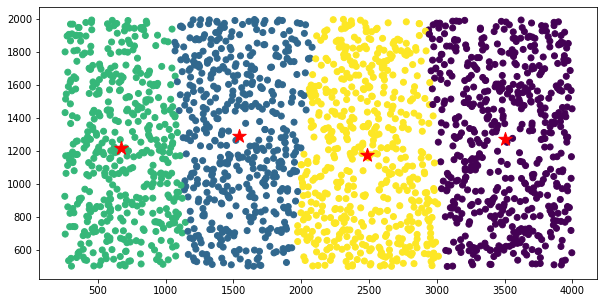

In [11]:
from sklearn.cluster import KMeans


# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=4)
# Se aprende el 
modelo = modelo.fit(Dx)
# Predicting the clusters
Dyp_sk = modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Comparing with scikit-learn centroids
print("Centros encontrados por...")
print("el método programado")
#print(cDx)
print("el método de Sci-kit Learn")
print(cDx_sk)


mC_sk = matriz_confusion(Dy,Dyp_sk)

print('Matriz de confusión:')
print(mC_sk)
print('El valor del error cometido es = ', medida_error(mC_sk))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_sk))
print('El valor F1 es = ', medida_f1(mC_sk))

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')


### Aglomerativo

Text(0, 0.5, 'Distancia euclideana')

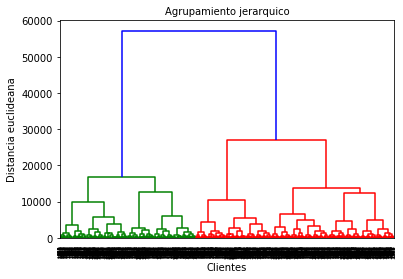

In [12]:
import scipy.cluster.hierarchy as sch
#Realizamos la gráfica a través del método de scipy llamado dendrograme. Como parametros le pasamos 
dendrogram = sch.dendrogram(sch.linkage(Dx, method = 'ward'))
plt.title('Agrupamiento jerarquico', fontsize = 10)
plt.xlabel('Clientes')
plt.ylabel('Distancia euclideana')


In [13]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')

In [14]:
y_hc = hc.fit_predict(Dx)

No handles with labels found to put in legend.


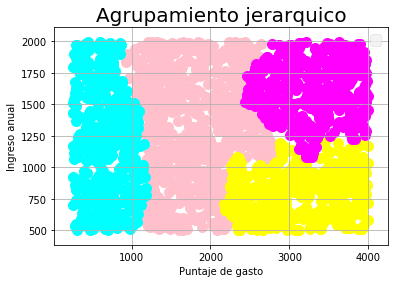

In [15]:
plt.scatter(Dx[y_hc == 0, 0], Dx[y_hc == 0, 1], s = 100, c = 'pink')
plt.scatter(Dx[y_hc == 1, 0], Dx[y_hc == 1, 1], s = 100, c = 'yellow')
plt.scatter(Dx[y_hc == 2, 0], Dx[y_hc == 2, 1], s = 100, c = 'cyan')
plt.scatter(Dx[y_hc == 3, 0], Dx[y_hc == 3, 1], s = 100, c = 'magenta')

plt.style.use('fivethirtyeight')
plt.title('Agrupamiento jerarquico', fontsize = 20)
plt.xlabel('Puntaje de gasto')
plt.ylabel('Ingreso anual')
plt.legend()
plt.grid()
plt.show()

### Divisivo

In [30]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def clustering_divisivo(mD, disimilitud_intracluster, separador, **kwargs):
    mParticiones = np.zeros(mD.shape[0]**2,dtype=np.int8)
    mParticiones.shape = (mD.shape[0],Dx.shape[0])

    for n in (np.arange(mD.shape[0]-1)+1):
        mParticiones[:,n] = mParticiones[:,n-1]

        # calcular la disimilitud intracluster
        # y elegir el que tenga mas
        rDisIntraCluster = disimilitud_intracluster(mD, mParticiones[:,n], n)
        iClusterADiv = np.argmax(rDisIntraCluster)

        iAClusterNuevo = separador(mD, mParticiones[:,n], iClusterADiv, **kwargs)

        mParticiones[iAClusterNuevo,n] = n
    return mParticiones

def disimilitud_diametro(mD, particion, n):
    res = [ np.max((mD[ np.ix_(particion == pn , particion == pn) ] +
                    np.transpose(mD[ np.ix_(particion == pn , particion == pn) ]))/ 2)
           for pn in np.arange(n)]
    return res

def disimilitud_media(mD, particion, n):
    res = [np.sum(mD[ np.ix_(particion == pn , particion == pn) ])
                              / (np.sum(particion == pn)**2)
                              for pn in np.arange(n)]
    return res



In [31]:
def separacion_macnaughton_smith(mDglobal, particion, iCluster):
    indsClust = np.where(particion==iCluster)[0]
    mD = mDglobal[ np.ix_(indsClust , indsClust)]

    SA = np.array([np.argmax(1/((mD.shape[0]-1)*2)*(np.sum(mD,axis=0)+np.sum(mD,axis=1)))])
    SB = np.delete(np.arange(mD.shape[0]), SA)
    if (SB.size == 1):
        return indsClust[SA]

    while True:
        res = np.zeros(SB.size)
        # Para todos los elementos del cluster original SB
        for i in np.arange(SB.size):
            SBa = np.delete(SB,i) 
            res[i] = (# distancia media con los otros elementos de SB
                np.sum(mD[ SB[i] , SBa ]) + 
                np.sum(mD[ SBa , SB[i] ])
            ) / (2 * SBa.size) - (# distancia media con los elementos ya movidos a SA
                np.sum(mD[ SB[i] , SA ]) +
                np.sum(mD[ SA , SB[i] ])
            ) / (2 * SA.size)


        # Si en todos los casos (todas las posiciones del vector res) la distancia 
        # es negativa quiere decir que no existe ningún elemento en SB más cercano 
        # a SA que al resto de SB
        if res[res < 0].any(): #### TU CODIGO AQUI ####
            break

        iToChange = np.argmax(res)
        SA = np.sort(np.append(SA, SB[iToChange]))
        SB = np.delete(np.arange(mD.shape[0]), SA)

    # Devolveremos los índices de los elementos que pertenecerán 
    # al clúster SA
    return indsClust[SA]

In [32]:
def separacion_Kmeans(mDglobal, particion, iCluster, Dxglobal):
    indsClust = np.where(particion==iCluster)[0]
    Dx = Dxglobal[indsClust,:]
    
    modelo = KMeans(n_clusters=2)#### TU CODIGO AQUI ####)
    modelo = modelo.fit(Dx)
    Dyp = modelo.predict(Dx)

    # Devolveremos los índices de los ejemplos asignados 
    # al segundo clúster
    return indsClust[Dyp==1]

In [33]:
# Muestra los ejemplos coloreados según su pertenencia a los clústeres
# K indica el número de clústeres a mostrar a partir de la jerarquía
def plot_particion_K(Dx, mParticiones,K):
    cmap = get_cmap('tab20')
    vals = np.arange(Dx.shape[0]+2)/(Dx.shape[0]+2)
    rgba = cmap(vals[np.arange(Dx.shape[0])+1])

    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(Dx[:,0],Dx[:,1], c=rgba[mParticiones[:,K-1],:])

# Muestra el plot de todas las particiones posibles de la jerarquía
def plot_particiones(Dx, mParticiones):
    for k in np.arange(mParticiones.shape[1]):
        plot_particion_K(Dx, mParticiones,k+1)

# Muestra el dendrograma de la jerarquía
def plot_dendrograma_de_mparticiones(mD, mParticiones):
    nPasos = mD.shape[0]-1
    distancias = np.zeros(nPasos)
    tamanyos = np.zeros(nPasos)
    uniones = np.zeros(2*nPasos,dtype=np.int8)
    uniones.shape=(nPasos,2)

    mNParticiones = mParticiones.copy()
    for n in np.arange(mNParticiones.shape[0]):
        valor = mParticiones[n,mNParticiones.shape[1]-1]
        mNParticiones[mParticiones==valor] = n

    k = 0
    aux = np.array(range(mNParticiones.shape[1]-1))
    for n in aux[::-1]:
        # cual es el diferente?
        prim_diferencia = np.where(mParticiones[:,n]!=mParticiones[:,n+1])[0][0]
        submatriz = mNParticiones[:,:n+1]
        submatriz[submatriz==mNParticiones[prim_diferencia,n]] = mNParticiones.shape[1]+k
        mNParticiones[:,:n+1] = submatriz
        uniones[k,:] = np.unique(mNParticiones[mNParticiones[:,n]==mNParticiones.shape[1]+k,n+1])
        tamanyos[k] = np.sum(mNParticiones[:,n]==mNParticiones.shape[1]+k)

        vs = mNParticiones[:,n+1]
        distancias[k] = 1 / (2 * tamanyos[k]) * (    
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,0])[0],
                              np.where(vs == uniones[k,1])[0])])+
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,1])[0],
                              np.where(vs == uniones[k,0])[0])]))
        k += 1

    distancias = np.arange(uniones.shape[0])
    # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
    mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

    plt.figure(figsize=(25, 10))
    plt.title('Dendrograma de Clustering Jerárquico')
    plt.xlabel('Índice del caso')
    plt.ylabel('Distancia')
    dendrogram(mEnlaces)
    plt.show()

In [34]:
mD = matriz_distancias(Dx, distancia_euclidiana)
K = 4 # parametro para mostrar una particion

# Usando disimilitud media y el método de separacion de Macnaughton-Smith
mParticiones = clustering_divisivo(mD, disimilitud_media, separacion_macnaughton_smith)
print(mParticiones)
#plot_dendrograma_de_mparticiones(mD, mParticiones)
#plot_particion_K(Dx, mParticiones, K)

/Users/german/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


ValueError: attempt to get argmax of an empty sequence

In [21]:
mParticiones = clustering_divisivo(mD, disimilitud_diametro, separacion_Kmeans, Dxglobal=Dx)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

ValueError: zero-size array to reduction operation maximum which has no identity